# Longitudinal Stance Classification in Social Media Conversations

## Table of Contents

>[Longitudinal Stance Classification in Social Media Conversations](#folderId=1iTnuGIb7YqZJoRAug0YVy-Z6lH-rGq6N&updateTitle=true&scrollTo=GWWP6za9jNTm)

>>[Table of Contents](#folderId=1iTnuGIb7YqZJoRAug0YVy-Z6lH-rGq6N&updateTitle=true&scrollTo=h7BJmDhXjrAm)

>>[Prepare your environment](#folderId=1iTnuGIb7YqZJoRAug0YVy-Z6lH-rGq6N&updateTitle=true&scrollTo=qTupgO23G9xv)

>>>[If Using Colab](#folderId=1iTnuGIb7YqZJoRAug0YVy-Z6lH-rGq6N&updateTitle=true&scrollTo=XEUIL1JjHFN8)

>>>[Install dependencies](#folderId=1iTnuGIb7YqZJoRAug0YVy-Z6lH-rGq6N&updateTitle=true&scrollTo=QHrvGjxkD-yI)

>>>[Import necessary packages](#folderId=1iTnuGIb7YqZJoRAug0YVy-Z6lH-rGq6N&updateTitle=true&scrollTo=X2lzRHP0NZEN)



>>[Dataset: RumourEval-2017](#folderId=1iTnuGIb7YqZJoRAug0YVy-Z6lH-rGq6N&updateTitle=true&scrollTo=sklQD7xgkeN0)


>>[Data conversion for the longitudinal task](#scrollTo=gLSKNxsUMVAZ&line=1&uniqifier=1)

>>[Embedding Posts into vector space](#scrollTo=fV1fSnuI_hLr&line=1&uniqifier=1)

>>[Formatting the data for ML processing](#scrollTo=FIcFxBXHAmaw&line=1&uniqifier=1)

>>[Building a longitudinal LSTM model](#scrollTo=bfeD-c0X-jA-&line=1&uniqifier=1)

>>[Building a static LSTM model](#scrollTo=4RWfzehfL2PA&line=10&uniqifier=1)

>>[Evaluation of models](#scrollTo=ksntq3ebalA3&line=1&uniqifier=1)
>>>[Post-level evaluation](#scrollTo=VzS2hb8obJzk&line=1&uniqifier=1)

>>>[Timeline-level evaluation](#scrollTo=lEpOemdvbVWm&line=1&uniqifier=1)

## Prepare your environment

### If Using Colab

Link Colab to your Google Drive to access and save files

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Upload the data from your course to your Google Drive. For this notebook you will need *rumoureval* folder.


If not using Colab, download the data from your course, place it in your working directory and update the filepaths in the notebook if necessary. 

### Install dependencies

In [2]:
!pip install torch
!pip install sentence-transformers
!pip install tweet-preprocessor
!pip install emoji==0.6.0
!pip install poutyne
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 81.1 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=2296c938652b3b1493e862a3631aae97dc87234c2311933b5c8c93844ba6abff
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers
Looking in indexes: https://pypi.o

### Import necessary packages

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import json
import re
import pickle
import preprocessor as p

from torch.utils.data import DataLoader
from copy import deepcopy
from sentence_transformers import SentenceTransformer
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence, pad_sequence, PackedSequence
from torch import nn

torch.manual_seed(1)

dir_path = '/content/gdrive/MyDrive/ResponsibleAI/draft-deliveries/longitudinal_workspace'

## Dataset: RumourEval-2017

We want to track how support towards a rumour develops over time by tracking the level of supporting and denying/questioning tweets in the conversation over time. 

This dataset contains Twitter conversations discussing rumours. Rumour story is usually conveyed in the source tweet.  Each tweet in the conversation is labelled with its stance towards the rumour as either **Supporting**, **Denying**, **Questioning** or **Commenting** as illustrated below.

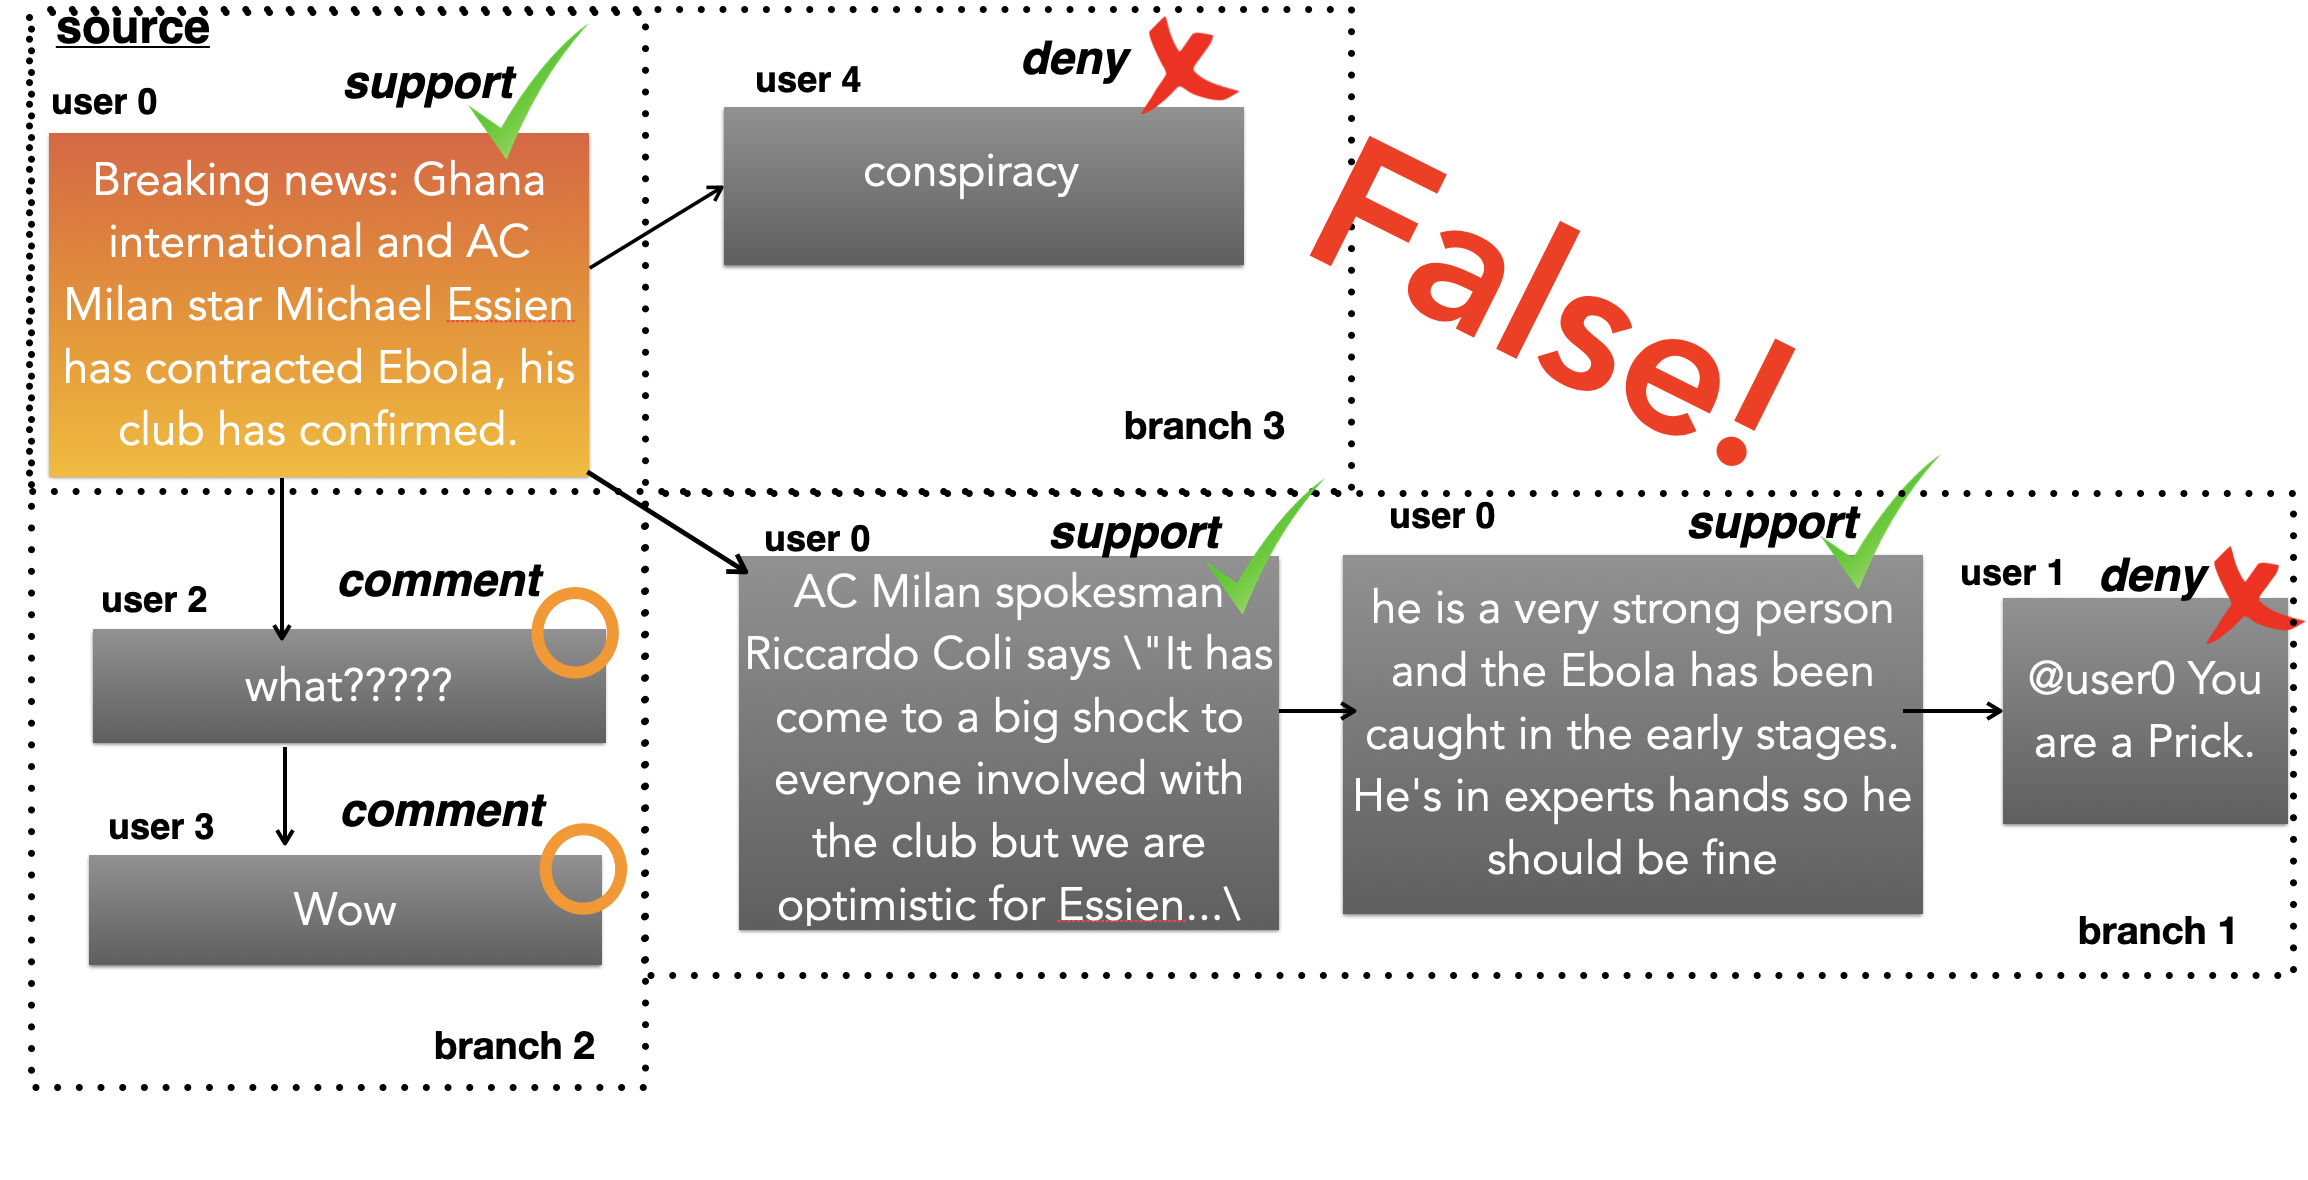

Load the dataset

In [63]:
def listdir_nohid(path): # ignores hidden files
    
    files = os.listdir(path)
    newfiles = [i for i in files if i[0] != '.']
    
    return newfiles

We load the data for Rumour Eval's Task A: this contains information about the stance of each tweet. We use the same train/dev/test split as the shared task.

In [ ]:
#_____Load labels and split for task A_____    
path_to_split = os.path.join(dir_path, 'RumourEval2017_data/semeval2017-task8-dataset/traindev')

devfileA = 'rumoureval-subtaskA-dev.json'
with open(os.path.join(path_to_split,devfileA)) as f:
    for line in f:
        devA = json.loads(line)

trainfileA = 'rumoureval-subtaskA-train.json'
with open(os.path.join(path_to_split,trainfileA)) as f:
    for line in f:
        trainA = json.loads(line)
dev_tweetsA = devA.keys()
train_tweetsA = trainA.keys()

path_to_test_threads = os.path.join(dir_path,'RumourEval2017_data/semeval2017-task8-test-data')
path_to_test_labels = os.path.join(dir_path,'RumourEval2017_data/subtaska.json')
with open(path_to_test_labels) as f:
    for line in f:
        testA = json.loads(line)
    

We load the data for Rumour Eval's Task B: this contains information about the veracities of each claim. We use the same train/dev/test split as the shared task.

In [ ]:
#_____Load labels and split for task B_______ 
path_to_split = os.path.join(dir_path,'RumourEval2017_data/semeval2017-task8-dataset/traindev')
devfile = 'rumoureval-subtaskB-dev.json'
with open(os.path.join(path_to_split,devfile)) as f:
    for line in f:
        dev = json.loads(line)

trainfile = 'rumoureval-subtaskB-train.json'
with open(os.path.join(path_to_split,trainfile)) as f:
    for line in f:
        train = json.loads(line)

dev_tweets = dev.keys()
train_tweets = train.keys()

path_to_test_threads = os.path.join(dir_path, 'RumourEval2017_data/semeval2017-task8-test-data')
path_to_test_labels = os.path.join(dir_path, 'RumourEval2017_data/subtaskb.json')
with open(path_to_test_labels) as f:
    for line in f:
        test = json.loads(line)
        
all_labels_B = {'train':train,'dev':dev,'test':test}
    

Save the twitter threads according to test/dev/train split in a dictionary  such that each tweet conversation contains information including:

*   the veracity label of the claim
*   the stance labels of posts (claim and replies)
*   the time stamps of the posts
*   text fields of posts
*   other metadata


In [ ]:
#_____Load folds and conversations for each partition using information from Task A and B___

def read_RumEv():
    
    # Load train and dev partitions
    path_to_folds = os.path.join(dir_path,'RumourEval2017_data/semeval2017-task8-dataset/rumoureval-data')
    folds=listdir_nohid(path_to_folds) 
    
    cvfolds = {}
    allconv = []
    weird_conv = []
    weird_struct = []

    train_dev_split = {}
    train_dev_split['dev'] = []
    train_dev_split['train'] = []
    train_dev_split['test'] = []
    for nfold,fold in enumerate(folds):
        path_to_tweets = os.path.join(path_to_folds, fold)
        tweet_data =  listdir_nohid(path_to_tweets)
        
        conversation = {}
        for foldr in tweet_data:
            # which set conversation belongs to
            conversation['id']=foldr
            if foldr in dev_tweets:
                convset = 'dev'    
                # find its label
                conversation['veracity'] = dev[foldr]
            elif foldr in train_tweets:
                convset = "train"
                conversation['veracity'] = train[foldr]
            else:
                print ("Conversation  not found", foldr)
            
            path_src = path_to_tweets+'/'+foldr+'/source-tweet'
            files_t=listdir_nohid(path_src) 
           
            with open(os.path.join(path_src,files_t[0])) as f:
                    for line in f:
                        src = json.loads(line)
                        src['used']=0
                        scrcid = src['id_str']
                        src['set'] = convset
                        src['label'] = conversation['veracity']
                        src['conv_id'] = foldr
                        
    #                    convset  - which set it belongs to
    #                    scrcid - string id of tweet can be key in setA
                        if convset == 'dev':
                            stance = devA[scrcid]
                        elif convset == 'train':   
                            stance = trainA[scrcid]
                        else:
                            print ("Tweet is not found in dev or train")
                        src['stance'] = stance 
            conversation ['source'] = src
                         
            if src['text'] is None:
                print ("Tweet has no text", src['id'])
                
            tweets = []
            path_repl = path_to_tweets+'/'+foldr+'/replies'
            files_t=listdir_nohid(path_repl) 
            if len(files_t)<1:
                print ("No replies", foldr)
            
            for repl_file in files_t:
                with open(os.path.join(path_repl, repl_file)) as f:
                    for line in f:
                        tw = json.loads(line)
                        tw['used']=0
                        replyid = tw['id_str']
                        tw['set'] = convset
                        tw['label'] = conversation['veracity']
                        tw['conv_id'] = foldr
                         
                        if convset == 'dev':
                            stance = devA[replyid]
                        elif convset == 'train':   
                            stance = trainA[replyid]
                        else:
                            print ("Tweet is not found in dev or train")
                        tw['stance'] = stance
                        tweets.append(tw) 
                        
                        if tw['text'] is None:
                            print ("Tweet has no text", tw['id'])
            
            conversation['replies'] = tweets
            path_struct = path_to_tweets+'/'+foldr+'/structure.json'
            with open(path_struct) as f:
                    for line in f:
                        struct = json.loads(line)
            
            if len(struct)>1:
    #            print "Structure has more than one root", 
                new_struct = {}
                new_struct[foldr] = struct[foldr]
                struct = new_struct
                weird_conv.append(conversation.copy())
                weird_struct.append(struct)
                # Take the item from the strucutre that's key is same as source tweet id
                
            conversation['structure'] = struct     
            train_dev_split[convset].append(conversation.copy())
            print('Saving conversation ', conversation['id'])
            allconv.append(conversation.copy())
        cvfolds[fold] = allconv
        allconv = []
    


    # Load testing partition
    path_to_test = os.path.join(dir_path, 'RumourEval2017_data/semeval2017-task8-test-data')
    test_folders = listdir_nohid(path_to_test)
   
    conversation = {}
    for tfldr in test_folders:
        if tfldr in test.keys():
            conversation['id']=tfldr            
            conversation['veracity'] = test[tfldr]
            path_src = path_to_test+'/'+tfldr+'/source-tweet'
            files_t=listdir_nohid(path_src) 
            with open(os.path.join(path_src,files_t[0])) as f:
                for line in f:
                    
                    src = json.loads(line)
                    src['used']=0
                    stance = testA[src['id_str']]
                    src['stance'] = stance

            conversation ['source'] = src
            tweets = []
            path_repl = path_to_test+'/'+tfldr+'/replies'
            files_t=listdir_nohid(path_repl) 
            
            for repl_file in files_t:
                with open(os.path.join(path_repl, repl_file)) as f:
                    for line in f:
                        tw = json.loads(line)
                        tw['used']=0 
                        if tw['id_str'] in testA.keys(): 
                            stance = testA[tw['id_str']]
                            tw['stance'] = stance
                        else:
                            print (tw['id_str'])

                tweets.append(tw) 
            conversation['replies'] = tweets
            path_struct = path_to_test+'/'+tfldr+'/structure.json'
            with open(path_struct) as f:
                for line in f:
                    struct = json.loads(line)  
            conversation['structure'] = struct     
            train_dev_split['test'].append(conversation.copy())
            print('Saving conversation ', conversation['id'])
    return train_dev_split

In [ ]:
data = read_RumEv()

Note that creating the data dictionary with conversations is a lengthy process due to numerous read operations being performed across many files. Therefore, the above cells are optional to run. Instead you can find the saved data dictionary [here](https://drive.google.com/file/d/1LgW_gEgomwD6eeHb9IEkUs5iRttpZPDu/view?usp=share_link).

In [5]:
saved_dictionary_path = os.path.join(dir_path,'conversations.json')

with open(saved_dictionary_path,'r') as f:
  data = json.load(f)

Check the format of the thread dictionary.

In [ ]:
data['dev'][0]

{'id': '580371845997682688',
 'veracity': 'true',
 'source': {'contributors': None,
  'truncated': False,
  'text': '#4U9525 took eight minutes to descend from 38,000 feet to impact, says Germanwings CEO Winkelmann.',
  'in_reply_to_status_id': None,
  'id': 580371845997682688,
  'favorite_count': 9,
  'source': '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>',
  'retweeted': False,
  'coordinates': None,
  'entities': {'symbols': [],
   'user_mentions': [],
   'hashtags': [{'indices': [0, 7], 'text': '4U9525'}],
   'urls': []},
  'in_reply_to_screen_name': None,
  'id_str': '580371845997682688',
  'retweet_count': 27,
  'in_reply_to_user_id': None,
  'favorited': False,
  'user': {'follow_request_sent': False,
   'profile_use_background_image': False,
   'profile_text_color': '000000',
   'default_profile_image': False,
   'id': 5943072,
   'profile_background_image_url_https': 'https://pbs.twimg.com/profile_background_images/588919474/twitter-44jo

## Data conversion for the longitudinal task

Convert conversation thread to linear timeline: we use timestamps of each post in the twitter thread to obtain a chronologically ordered list. 

In [6]:
def tree2timeline(conversation):
    timeline = []    
    timeline.append((conversation['source']['id'],conversation['source']['stance']))
    replies = conversation['replies']
    replies_idstr = []
    replies_timestamp = []
    for reply in replies:
        replies_idstr.append((reply['id'],reply['stance']))
        replies_timestamp.append(reply['created_at'])
    
    sorted_replies = [x for (y,x) in sorted(zip(replies_timestamp,replies_idstr))]
    timeline.extend(sorted_replies)
    return timeline

We use the gold labels from Task A to track the ratio of support/opposition stance towards the claim. Spans of post instances when the ratio tips over (from support to opposition or vice-versa) will be called ***switches***.

The labelling scheme for the longitudinal task is set in the following way:


*   0 = no switch has happened or the balance between support and opposition is equal
*   1 = a switch from opposition to support starts
*   2 = a switch from opposition to support continues
*   -1 = a switch from support to opposition starts
*   -2 = a switch from support to opposition continues








In [7]:
stance_timelines = {'dev':[],'train':[],'test':[]}
switch_timelines = {'dev':[],'train':[],'test':[]}
check = []
count_switch_threads = 0
all_support_switches = 0
all_oppose_switches = 0
count_threads = 0

for subset in  list(data.keys()):
  count_threads += len(data[subset])
  for conv in data[subset]:
    timeline = tree2timeline(conv)
    stance_timelines[subset].append(timeline)
    support = 0
    deny = 0
    old_sum = 0
    switch_events = []
    for i, s  in enumerate(timeline):
 
        if s[1] == "support":
            support = support+1
        elif s[1]=="query" or s[1]=="deny":
            deny = deny+1
        
        new_sum = support - deny
        check.append(new_sum)
        
             
        if i!=0 and old_sum==0 and new_sum!=0:
            # A switch in stance from supporting to opposing the claim starts
            if new_sum<0:
              switch_events.append((s[0],-1))
            # A switch in stance from opposing to supporting the claim starts
            elif new_sum>0:
              switch_events.append((s[0],1))
        elif i!=0 and old_sum<0 and new_sum<0 and -1 in [x[1] for x in switch_events]:
            # A switch in stance from supporting to opposing the claim continues
            switch_events.append((s[0],-2))
        elif i!=0 and old_sum>0 and new_sum>0 and 1 in [x[1] for x in switch_events]:
            # A switch in stance from opposing to supporting the claim continues
            switch_events.append((s[0],2))
        
        else:
            switch_events.append((s[0],0))
        old_sum = new_sum


    support_switch = [x[1] for x in switch_events].count(1)
    oppose_switch = [x[1] for x in switch_events].count(-1)


    if (support_switch + oppose_switch>0):
        count_switch_threads = count_switch_threads+1
        all_support_switches += support_switch
        all_oppose_switches += oppose_switch

    switch_timelines[subset].append(switch_events)
print('Ratio of threads with switches / total number of threads: {}/{}'.format(count_switch_threads,count_threads))
print('# of switches of stance from support to opposition of claim: ',all_support_switches)
print('# of switches of stance from opposition to support of claim: ',all_oppose_switches)

Ratio of threads with switches / total number of threads: 155/325
# of switches of stance from support to opposition of claim:  103
# of switches of stance from opposition to support of claim:  132


We observe that approximately half of the threads in the corpus exhibit switches of stance (either from most posts questioning or opposing the claim to supporting it and vice-versa). Such threads are expected to have 1.5 switches on average with more switches tending to be from support to opposition; this intuitively makes sense since evidence to refute the rumour surfaces at a later stage than the claim publication time.

In the example below, the claim  "*Canadian soldier who was shot has died*" is refuted by replies denying the information ("*There are reports he is still alive*") or questioning it ("*Let's wait until we really know*"). Note that the switch in stance taking place after the 4th reply and continues until the end of timeline.

In [ ]:
idx = 14
print(switch_timelines['train'][idx])
example_thread = data['train'][idx]

thread_comments = []
thread_comments.append(example_thread['source']['text'])
thread_comments.extend([x['text'] for x in example_thread['replies']])

for i,comment in enumerate(thread_comments):
  print(i, comment, stance_timelines['train'][idx][i][1].upper())


[(524947674164760577, 0), (524947899982290944, 0), (524948114113703936, 0), (524952276109373442, 0), (524952396259409920, -1), (524952460897828865, -2), (524953683172524032, -2), (524955418955902976, -2), (524956642454941696, -2), (524959514995724288, -2), (524960036179968001, -2), (524960914450415617, -2), (524961467431665664, -2), (524961925239959552, -2), (524962300466569216, -2), (524962623562186752, -2), (524962626615664640, -2), (524962753036185600, -2), (524964141296259072, -2), (524964193813155841, -2), (524964503579262976, -2)]
0 BREAKING NEWS: New York Times is reporting the Canadian soldier who was shot has died from their injuries. Heartbreaking. #cdnpoli #ableg SUPPORT
1 @Donnajcherold @DaveBeninger New report indicates he is alive but obviously gravely injured. I'm not sure where New York Times got that. COMMENT
2 @NatriceR @Donnajcherold @DaveBeninger But both would indicate there is need to increase surveillance &amp; ability to detain COMMENT
3 @NatriceR @doctorfullert

## Embedding Posts into vector space

For each thread, we embed its posts into a semantic space using the [Distil Roberta](https://huggingface.co/sentence-transformers/paraphrase-distilroberta-base-v1) model for paraphrasing. This will generate 768 dimensional dense vectors and can be applied on both sentences and paragraphs. 

Before the embedding step, we preprocess the tweets to remove unnecessary white space and emojis, replace links and mentions with placeholders.

In [68]:
#Preprocess function for tweets

p.set_options(p.OPT.EMOJI, p.OPT.SMILEY)
def preprocess_tweet(tweet):
    tweet = tweet.lower()
    tweet = tweet.replace('\n','').replace('\t','')
    tweet = re.sub(r'http\S+', 'URL', tweet)
    tweet = re.sub(r'@\w+', 'MENTION', tweet)
    tweet = p.clean(tweet)
 
    return tweet

In [38]:
#Vectorizing function for contextual embeddings
def vectorize(tweet):
    emb_model = SentenceTransformer("paraphrase-distilroberta-base-v1")
    vectorised_tweet = emb_model.encode([tweet]).reshape(1, -1)
    return vectorised_tweet

#Vectorizing function for word embeddings
def vectorize2(tweet):
    vectorised_tweet = []
    emb_model = SentenceTransformer("paraphrase-distilroberta-base-v1")
    for word in tweet.split():
        vectorised_tweet.append(emb_model.encode([word]).reshape(1, -1))
    return vectorised_tweet


example_tweet = 'Heya how you doing? 😉 @somemention'
print('Tweet: ',example_tweet)
pp_tweet = preprocess_tweet(example_tweet)
print('Preprocessed tweet: ', pp_tweet)
print(type(vectorize2(pp_tweet)))

Tweet:  Heya how you doing? 😉 @somemention
Preprocessed tweet:  heya how you doing? MENTION
<class 'list'>


The contextual embeddings have been saved in an external file you can find [here](https://drive.google.com/file/d/1-2etRrHroknRbskXgeHbU0k9aJVWEPQh/view?usp=share_link).

In [8]:
emb_file_path = os.path.join(dir_path,'context_emb_file') 

if os.path.isfile(emb_file_path):
    # If the embedding file exists, we can load the embeddings directly from the file
    with open(emb_file_path, "rb") as handle:
        emb_data = pickle.load(handle)

else:
  # Otherwise, recreate these embeddings
  emb_data = {'dev':[],'train':[],'test':[]}
  for key in data.keys():
    for conversation in data[key]:
      emb_conv = {'source':{},'replies':[]}
      count_posts = len(conversation['replies'])+1
      print("Creating DistilRoberta embeddings for {} posts...".format(count_posts ))
      
      emb_conv['source']['id'] = conversation['source']['id']
      source = conversation['source']['text']
      emb_conv['source']['emb'] = vectorize(preprocess_tweet(source))

      for reply in conversation['replies']:
        entry = {}
        entry['id'] = reply['id']
        entry['emb'] = vectorize(preprocess_tweet(reply['text']))
        emb_conv['replies'].append(entry)
    
      emb_data[key].append(emb_conv)
      
  with open(emb_file_path,'wb') as g:
    pickle.dump(emb_data, g)


print("Finished creating contextual embeddings.")

Finished creating contextual embeddings.


In [9]:
emb_file_path = os.path.join(dir_path,'word_emb_file') 

if os.path.isfile(emb_file_path):
    # If the embedding file exists, we can load the embeddings directly from the file
    with open(emb_file_path, "rb") as handle:
        word_emb_data = pickle.load(handle)

else:
  # Otherwise, recreate these embeddings
  word_emb_data = {'dev':[],'train':[],'test':[]}
  for key in data.keys():
    for conversation in data[key]:
      emb_conv = {'source':{},'replies':[]}
      count_posts = len(conversation['replies'])+1
      print("Creating DistilRoberta embeddings for {} posts...".format(count_posts ))
      
      emb_conv['source']['id'] = conversation['source']['id']
      source = conversation['source']['text']
      emb_conv['source']['emb'] = vectorize2(preprocess_tweet(source))

      for reply in conversation['replies']:
        entry = {}
        entry['id'] = reply['id']
        entry['emb'] = vectorize2(preprocess_tweet(reply['text']))
        emb_conv['replies'].append(entry)
    
      word_emb_data[key].append(emb_conv)
      
  with open(emb_file_path,'wb') as g:
    pickle.dump(emb_data, g)


print("Finished creating word embeddings.")

Finished creating word embeddings.


The word embeddings have been saved to a file you can find [here](https://drive.google.com/file/d/1P1vuW_K9nZCGCk-ScV90LbOvVu_INJq8/view?usp=share_link).

## Formatting the data for ML processing

For the purpose of this module, we will solely focus on the task of predicting spans of switches in stance. 

This means that we are no longer differentiating between the two types of switches oppose -> support (+) and support -> oppose (-) or the difference between the start of a switch (1 and -1 respectively) or continuation of a switch (2 and -2 respectively). These serve as directions for future work.

Therefore, we convert our annotation to binary labels:


*   0 = no switch (all previous zero labels remain the same)
*   1 = switch (all previous non-zero labels become 1)



In [10]:
def simplify_label(y):
    #If the label is -2,-1,2 this is is relabeled to 1
    if y != 0:
        y = 1   
    return y    

print(switch_timelines['train'][14])

for subset in ['train','dev','test']:
    for i,thread in enumerate(switch_timelines[subset]):
        switch_timelines[subset][i] = [(x,simplify_label(y)) for (x,y) in thread]
        
print(switch_timelines['train'][14])

[(524947674164760577, 0), (524947899982290944, 0), (524948114113703936, 0), (524952276109373442, 0), (524952396259409920, -1), (524952460897828865, -2), (524953683172524032, -2), (524955418955902976, -2), (524956642454941696, -2), (524959514995724288, -2), (524960036179968001, -2), (524960914450415617, -2), (524961467431665664, -2), (524961925239959552, -2), (524962300466569216, -2), (524962623562186752, -2), (524962626615664640, -2), (524962753036185600, -2), (524964141296259072, -2), (524964193813155841, -2), (524964503579262976, -2)]
[(524947674164760577, 0), (524947899982290944, 0), (524948114113703936, 0), (524952276109373442, 0), (524952396259409920, 1), (524952460897828865, 1), (524953683172524032, 1), (524955418955902976, 1), (524956642454941696, 1), (524959514995724288, 1), (524960036179968001, 1), (524960914450415617, 1), (524961467431665664, 1), (524961925239959552, 1), (524962300466569216, 1), (524962623562186752, 1), (524962626615664640, 1), (524962753036185600, 1), (52496

In [24]:
# Define our own Dataset types so that batch-loading is easy
class MyDataset(torch.utils.data.Dataset):
    def __init__(self,data,target):
        self.data = data
        self.target = target
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]   
        #return {'data': x, 'target': y}
        return x,y
  
    def __len__(self):
        return len(self.data)



class MyDataset2(torch.utils.data.Dataset):
    def __init__(self,data,target,signal):
        self.data = data
        self.target = target
        self.signal = signal
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]  
        z = self.signal[index] 

        #return {'data': x, 'target': y}
        return x,y,z
  
    def __len__(self):
        return len(self.data)

In [25]:
for subset in ['train','dev','test']:   
    # Data for longitudinal model
    data = []
    target = []
    # Data for static model
    data_static = []
    target_static = []
    signal_static = []

    for thread in switch_timelines[subset]:
        # Find saved contextual embeddings for this thread
        for i, embs in enumerate(emb_data[subset]):
            if embs['source']['id']==thread[0][0]:
              break
        
        thread_label = [thread[0][1]]
        thread_emb_data = [embs['source']['emb'][0]]

        for i,post in enumerate(thread):
            if i==0:
              continue
            for emb in embs['replies']:
              if emb['id']== post[0]:
                break
            thread_label.append(post[1])
            thread_emb_data.append(emb['emb'][0])

        data.append(thread_emb_data)
        target.append(thread_label)



        # Find saved word embeddings for this thread
        for i, embs2 in enumerate(word_emb_data[subset]):
            if embs2['source']['id']==thread[0][0]:
              break
        
        data_static.append([x[0] for x in embs2['source']['emb']])
        target_static.append(thread[0][1])
        signal_static.append(embs2['source']['id'])

        for i,post in enumerate(thread):
            if i==0:
              continue
            for emb in embs2['replies']:
              if emb['id'] == post[0]:
                break
            target_static.append(post[1])
            data_static.append([x[0] for x in emb['emb']])
            signal_static.append(embs2['source']['id'])




    
    if subset =='train':
      train_dataset = MyDataset(data,target)
      train_dataset_static = MyDataset2(data_static,target_static,signal_static)
    elif subset == 'test':
      test_dataset = MyDataset(data,target)
      test_dataset_static = MyDataset2(data_static,target_static,signal_static)
    else:
      dev_dataset = MyDataset(data,target) 
      dev_dataset_static = MyDataset2(data_static,target_static,signal_static)    


  The collating function can add padding to the sequences so all can have the same length as the longest one. 

  The word embeddings are padded with vectors of 0s and the labels are padded with -100s. Padding with -100 is done because of the cross-entropy loss and the
accuracy metric ignores the targets with values -100.

In [13]:
def pad_collate_fn(batch):
    """
    Args:
        batch (List[List, List]): The batch data, where the first element
        of the tuple are the word embeddings and the second element are the target
        labels.

    Returns:
        A tuple (x, y). The element x is a tensor of packed sequence .
        The element y is a tensor of padded labels. 
    """

    # This gets us two lists of tensors and a list of integer.
    # Each tensor in the first list is a sequence of word vectors.
    # Each tensor in the second list is a sequence of labels.
    # The list of integer consist of the lengths of the sequences in order.
    sequences_vectors, sequences_labels, lengths = zip(*[
        (torch.FloatTensor(np.stack(seq_vectors)), torch.LongTensor(labels), len(seq_vectors))
        for (seq_vectors, labels) in sorted(batch, key=lambda x: len(x[0]), reverse=True)
    ])

    lengths = torch.LongTensor(lengths)

    padded_sequences_vectors = pad_sequence(sequences_vectors, batch_first=True, padding_value=0)
    pack_padded_sequences_vectors = pack_padded_sequence(padded_sequences_vectors, lengths.cpu(), batch_first=True)  # We pack the padded sequence to improve the computational speed during training
    padded_sequences_labels = pad_sequence(sequences_labels, batch_first=True, padding_value=-100)

    return pack_padded_sequences_vectors, padded_sequences_labels


train_data_loader = DataLoader(train_dataset, batch_size=1,collate_fn=pad_collate_fn)
test_data_loader = DataLoader(test_dataset, batch_size=1,collate_fn=pad_collate_fn)
dev_data_loader = DataLoader(dev_dataset, batch_size=1,collate_fn=pad_collate_fn)


## Building a longitudinal LSTM model

Inspired by the work of [Tsakalidis et al. (2022)](https://aclanthology.org/2022.acl-long.318.pdf) on detecting moments of change in user timelines, we adapt their best performing model to our task. Similar to them, we use an LSTM-based model which employs contextual embeddings for its prediction.

In particular, we define the architecture of the model as 2 LSTM layers followed by a fully connected linear layer.





In [57]:
class FullNetWork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_state = None

        self.lstm_network1 = nn.LSTM(input_size=768,
                       hidden_size=768,
                       num_layers=1,
                       bidirectional=False,
                       batch_first=True)
        
        self.lstm_network2 = nn.LSTM(input_size=768,
                       hidden_size=768,
                       num_layers=1,
                       bidirectional=False,
                       batch_first=True)
        
        
        self.fully_connected_network = nn.Linear(in_features = 768, out_features=2)

    def forward(self, pack_padded_sequences_vectors: PackedSequence):
        """
            Defines the computation performed at every call.
        """
        lstm_out1, _ = self.lstm_network1(pack_padded_sequences_vectors)
        lstm_out2, _ = self.lstm_network2(lstm_out1)
        lstm_out, _ = pad_packed_sequence(lstm_out2, batch_first=True)
        tag_space = self.fully_connected_network(lstm_out)
        
        return tag_space.transpose(-1, 1)


Use Adam Optimizer with learning rate of 0.0001 and optimise for the Cross Entropy loss.

In [66]:
num_epochs = 150
learning_rate = 0.0001 

long_model = FullNetWork()
optimizer = torch.optim.Adam(long_model.parameters(),lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


Train the model and save the best version of it (with lowest accumulated loss) across 150 epochs.

In [ ]:
long_model.train()

best_loss = 10000
for epoch in range(num_epochs):  # loop over the dataset multiple times
    acc_loss = 0   
    # Evaluate loss on training set, while performing backprop at the same time for each sample (batch) in the train_data_loader
    for i, train_data in enumerate(train_data_loader):
        inputs, y_true = train_data
        inputs, y_true = inputs.to(device), y_true.to(device)
        optimizer.zero_grad()

        # Forward
        y_pred = long_model(inputs)
        #y_pred = y_pred.argmax(axis=1)  # Convert predictions to label-encoding, if desired
       
        # Backpropagate
        loss = loss_function(y_pred, y_true)

        #Compute accumulated loss per epoch
        acc_loss += loss

        loss.backward()
        optimizer.step()  # Update weights
    
    print('Finished training for epoch {}.'.format(epoch))
    print('Epoch {}: loss = {}'.format(epoch,acc_loss/len(train_data_loader)))
    #Save the best model
    if acc_loss/len(train_data_loader)<best_loss:
        best_loss = acc_loss/len(train_data_loader)

        # Save state dictionary    
        model_path = os.path.join(dir_path,'longitudinal_lstm')
        torch.save(long_model.state_dict(), model_path)

In case of limited computing resources, the trained model's state dictionary is provided [here](https://drive.google.com/file/d/1rqQJjcFs2qIlHxqWawciOfSya_Ry8LNp/view?usp=share_link).

In [18]:
#Load the trained model
long_model = FullNetWork()
model_path = os.path.join(dir_path,'longitudinal_lstm')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
long_model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))

<All keys matched successfully>

## Building a static LSTM model

This will closely follow the implementation of the previous model with the only differences being the following:



1.   It relies on word embeddings instead of contextual embeddings (input = sequence of word representation for each word in the post)
2.   It makes predictions at post-level as opposed to timeline level (output = predicted switch label for the post)
  
Note that the static LSTM model operates on posts in isolation since it does not use semantic dependencies from previous posts in the timeline. This means that the training will contain more instances than in the previous use case.



In [15]:
class FullNetWork2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_state = None

        self.lstm_network1 = nn.LSTM(input_size=768,
                       hidden_size=768,
                       num_layers=1,
                       bidirectional=False,
                       batch_first=True)
        
        self.lstm_network2 = nn.LSTM(input_size=768,
                       hidden_size=768,
                       num_layers=1,
                       bidirectional=False,
                       batch_first=True)
        
        
        self.fully_connected_network = nn.Linear(in_features = 768, out_features=2)

    def forward(self, vectors):
        """
            Defines the computation performed at every call.
        """
        lstm_out1, _ = self.lstm_network1(vectors)
        lstm_out2,_ = self.lstm_network2(lstm_out1)
        final = self.fully_connected_network(lstm_out2[-1,:])
    
 
        return final

In [51]:
num_epochs = 20
learning_rate = 0.0001 

static_model = FullNetWork2()
optimizer = torch.optim.Adam(static_model.parameters(),lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
static_model.train()


best_loss = 10000
for epoch in range(num_epochs):  # loop over the dataset multiple times
    acc_loss = 0   
    # Evaluate loss on training set, while performing backprop at the same time for each sample (batch) in the train_data_loader
    for i, train_data in enumerate(train_dataset_static):

        inputs, y_true,_ = train_data
        inputs = torch.FloatTensor(np.stack(inputs))
        y_true = torch.tensor([y_true])
        #print(inputs,y_true)
        inputs, y_true = inputs.to(device), y_true.to(device)
        optimizer.zero_grad()

        # Forward
        y_pred = static_model(inputs)
        #y_pred = y_pred.argmax(axis=1)  # Convert predictions to label-encoding, if desired
        y_pred = y_pred.view(1,-1)

        # Backpropagate
        loss = loss_function(y_pred, y_true)
        if i%1000 ==0:
            print(i, loss)

        #Compute accumulated loss per epoch
        acc_loss += loss

        loss.backward()
        optimizer.step()  # Update weights
    
    print('Finished training for epoch {}.'.format(epoch))
    print('Epoch {}: loss = {}'.format(epoch,acc_loss/len(train_dataset_static)))
    #Save the best model
    if acc_loss/len(train_dataset_static)<best_loss:
        best_loss = acc_loss/len(train_dataset_static)

        # Save state dictionary    
        model_path = os.path.join(dir_path,'static_lstm')
        torch.save(static_model.state_dict(), model_path)

In case of limited computing resources, the trained model's state dictionary is provided [here](https://drive.google.com/file/d/1YvN6dU-iGgn1ntssRpurQkDRW1X-yFnH/view?usp=share_link).

In [61]:
#Load the trained model
static_model = FullNetWork2()
model_path = os.path.join(dir_path,'static_lstm')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
static_model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))


<All keys matched successfully>

## Evaluation of models

Evaluate the model on the test set and store the predictions. In this section we will discuss two views to interpret the results from: post-level and timeline-level.

In [20]:
performance = {'longitudinal':[],'static':[]}

Evaluate the longitudinal model.

In [ ]:
long_model.eval()
all_timeline_results = []

print('Testing the longitudinal model and saving the results.')
for test_data in test_data_loader:
    inputs, y_true = test_data
    with torch.no_grad():
        outputs = long_model(inputs)

    y_pred = long_model(inputs)
    y_pred = y_pred.argmax(axis=1)
    y_pred = y_pred[0].tolist()
    y_true = y_true[0].tolist()
    all_timeline_results.append((y_pred, y_true))
    print(y_pred,y_true)
print('Testing is done.')  

performance['longitudinal'] = all_timeline_results

Evaluate the static model.

In [62]:
static_model.eval()
all_timeline_results = []

print('Testing the static model and saving the results.')
y_preds = []
y_trues = []
for i,test_data in enumerate(test_dataset_static):

    inputs, y_true, signal = test_data
    inputs = torch.FloatTensor(np.stack(inputs))
    y_true = torch.tensor([y_true]).item()

    y_pred = static_model(inputs)
    y_pred = y_pred.view(1,-1)
    y_pred = y_pred.argmax(axis=1).item()
    
    if i==0:
        y_preds.append(y_pred)
        y_trues.append(y_true)
    else:
        if signal == old_signal:  #post is part of the same timeline
            y_preds.append(y_pred)
            y_trues.append(y_true)
        else:
            all_timeline_results.append((y_preds, y_trues))
            
            y_preds = [y_pred]
            y_trues = [y_true]
          
    old_signal = signal

all_timeline_results.append((y_preds, y_trues))
print(all_timeline_results, len(all_timeline_results))
print('Testing is done.')  

performance['static'] = all_timeline_results


Testing the static model and saving the results.
[([1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), ([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]), ([0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), ([0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), ([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), ([0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
#Sanity check 
for i,x in enumerate(performance['longitudinal']):
  print(len(x[0]),len(performance['static'][i][0]))


### Post-level Evaluation

The main drawback of post-level metrics is their inability to indicate model
suitability in predicting regions of change. This is a priority given the longitudinal nature of our task, predicting switches in stance over time.


In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score

def post_scores(y_true, y_pred,label):
   
    precision = precision_score(y_true,y_pred, pos_label = label,zero_division=1)
    recall = recall_score(y_true,y_pred, pos_label = label,zero_division=1)
    if precision+recall>0:
      f1 = (2*precision*recall)/(precision+recall)
    else:
      f1 = 0   

    return precision,recall,f1


In [70]:
for key in performance.keys():
    all_timeline_results = performance[key]
    print('Post-level performance for ',key.upper())
    precision_1_avg = 0
    precision_0_avg = 0

    recall_1_avg = 0
    recall_0_avg = 0

    f1_1_avg = 0
    f1_0_avg = 0

    for timeline_results in all_timeline_results:
        y_pred = timeline_results[0]
        y_true = timeline_results[1]
        precision_1,recall_1,f1_1 = post_scores(y_true,y_pred,1)
        precision_0,recall_0,f1_0 = post_scores(y_true,y_pred,0)
        precision_1_avg += precision_1
        precision_0_avg += precision_0

        recall_1_avg += recall_1
        recall_0_avg += recall_0

        f1_1_avg += f1_1
        f1_0_avg += f1_0

    print('Precision : {} (label 0) and {} (label 1)'.format(precision_1_avg/len(all_timeline_results), precision_0_avg/len(all_timeline_results)))
    print('Recall : {} (label 0) and {} (label 1)'.format(recall_1_avg/len(all_timeline_results), recall_0_avg/len(all_timeline_results)))
    print('F1 : {} (label 0) and {} (label 1)'.format(f1_1_avg/len(all_timeline_results), f1_0_avg/len(all_timeline_results)))
    print()



Post-level performance for  LONGITUDINAL
Precision : 0.6265172384743372 (label 0) and 0.6736707736707735 (label 1)
Recall : 0.6642239586937533 (label 0) and 0.7676821496881059 (label 1)
F1 : 0.4030464157230487 (label 0) and 0.6059461914954222 (label 1)

Post-level performance for  STATIC
Precision : 0.41462223890905886 (label 0) and 0.5914711656436067 (label 1)
Recall : 0.7231516532906168 (label 0) and 0.4158506574600839 (label 1)
F1 : 0.37470805343587826 (label 0) and 0.4345973221693122 (label 1)



### Timeline-level Evaluation

We adopt the novel metrics for capturing rare events in temporal windows introduced by Tsakalidis et al. (2022).

In particular, they calculate recall and precision by counting as “correct” a model prediction for label *l* if the prediction falls within a window of *w* posts around post labelled *l* in the gold standard. 

In [53]:
def timeline_scores(predicted_labels, actual_labels, window, label):
    '''
    Given the lists of predicted and actual labels, the label to calculate the metrics for and
    the window to use (allowing +-window predictions to be considered as accurate), it returns:
        (a) the precision using that window for the specified label
        (b) the recall -//-
        (c) the support (number of actual labels that we had to predict)
    '''
    # Find the indices of the specified predicted and actual label
    preds = [i for i in range(len(predicted_labels)) if predicted_labels[i]==label]
    actuals = [i for i in range(len(actual_labels)) if actual_labels[i]==label]

    # Check if we can proceed or not
    support = len(actuals)
    if len(actuals)==0: # cannot divide by zero (Recall is undefined)
        recall, precision = np.nan, np.nan 
        if len(preds)>0:
            precision = 0.0
    elif len(preds)==0: # cannot divide by zero (Precision is undefined, but Recall is 0)
        precision = np.nan
        recall = 0.0

    else:
        already_used = []
        for l in actuals: 
            for p in preds: 
                if (np.abs(l-p)<=window) & (p not in already_used): 
                    already_used.append(p) 
                    break 
        precision = len(set(already_used))/len(preds)
        recall = len(set(already_used))/len(actuals)
   
  
    
    return precision, recall, support

In [75]:
for key in performance.keys():
    all_timeline_results = performance[key]
    print(all_timeline_results)
    print('Timeline-level performance for ',key.upper())

    all_recalls_0 = []
    all_precisions_0 = []
    all_fscores_0 = []
    all_recalls_1 = []
    all_precisions_1 = []
    all_fscores_1 = []

    for timeline_results in all_timeline_results:
        y_pred = timeline_results[0]
        y_true = timeline_results[1]
        
        s_prec_0, s_rec_0, s_sup_0 = timeline_scores(y_pred, y_true, 1, 0)     
        s_fscore_0 = np.nan
        if s_prec_0+s_rec_0>0:
            s_fscore_0 = (2*s_prec_0*s_rec_0)/(s_prec_0+s_rec_0)
        elif s_prec_0+s_rec_0==0:
            s_fscore_0 = 0.0
     
        all_recalls_0.append(s_rec_0)
        all_precisions_0.append(s_prec_0)
        all_fscores_0.append(s_fscore_0)

        s_prec_1, s_rec_1, s_sup_1 = timeline_scores(y_pred, y_true, 1, 1)     
        s_fscore_1 = np.nan
        if s_prec_1+s_rec_1>0:
            s_fscore_1 = (2*s_prec_1*s_rec_1)/(s_prec_1+s_rec_1)
        elif s_prec_1+s_rec_1==0:
            s_fscore_1 = 0.0
        all_recalls_1.append(s_rec_1)
        all_precisions_1.append(s_prec_1)
        all_fscores_1.append(s_fscore_1)


    p_0 = np.nanmean(all_precisions_0)
    r_0 = np.nanmean(all_recalls_0)
    f1_0 = np.nanmean(all_fscores_0)

    p_1 = np.nanmean(all_precisions_1)
    r_1 = np.nanmean(all_recalls_1)
    f1_1 = np.nanmean(all_fscores_1)
    #print(all_precisions_1)
    #print(all_precisions_1)
    #print(all_fscores_1)


    print('Precision : {} (label 0) and {} (label 1)'.format(p_0,p_1))
    print('Recall : {} (label 0) and {} (label 1)'.format(r_0,r_1))
    print('F1 : {} (label 0) and {} (label 1)'.format(f1_0,f1_1))
    print()

[([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), ([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]), ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), ([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,